# General Pipeline

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import IPython
from IPython.display import Audio, HTML
from scipy.io import wavfile
import math
import cv2
import subprocess
import scipy
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams["figure.figsize"] = (14,4)
import librosa
from moviepy.editor import VideoFileClip, AudioFileClip, CompositeAudioClip
from matplotlib import cm
import moviepy
from os.path import abspath
from os.path import join as p_join

data_fpath = p_join(abspath(''), 'data')

## Data loading
Here is where songs + images can be loaded

The goal function are get_info and get_gif, which can be changed for more interesting parameter searching and mappings. 

### Song loading

#### Choose song

#### Song details

### Image loading

In [26]:
def resize_image(img, target_width=480):
    height, width, layers = img.shape
    scale = target_width / width
    target_width = int(width * scale)
    target_height = int(height * scale)
    dim = (target_width, target_height)
    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

## Data processing

### Function to extract features from audio

this function splits the audio in overlapping samples and computes features such das fourier decomposition, mean amplitude and phase for each sample. For each sample these are stored in a dictionary called "frame" which can easily be passed to each method that then uses these features to modify the image.

In [2]:
def normalize_frames(frames, norm_functions):
    return [
        { key: (norm_functions[key](value)
                if key in norm_functions else value)
         for key, value in frame.items() }
        for frame in frames
    ]

# function that takes audio as input and return different features
def get_info(audio_name, window_size):
    # audio_name -- name of audiofile
    # window_size -- we split audio into frames, this is the length of the frame in seconds
    x, sr = librosa.load(audio_name, sr = None)
    seconds = len(x) / sr
    frame_len = int(len(x) / (seconds / window_size))
    frames = []
    for ind in range(0, len(x) + 1, frame_len):
        current_amplitude = x[ind:ind + frame_len]
        fft = librosa.stft(current_amplitude, n_fft=len(current_amplitude), hop_length=len(current_amplitude))
        freqs = fft[:, 0]
        freqs = librosa.amplitude_to_db(abs(freqs))
        _, phase = librosa.magphase(fft)
        phase = phase[:, 0]
        frames.append({
            'amplitude':current_amplitude,
            'amplitude_abs_mean': np.mean(np.abs(current_amplitude)),
            'frequency':freqs,
            'phase':phase,
        })
        #timbre = 0
    print(len(frames))
    print(librosa.stft(x, n_fft=frame_len, hop_length = frame_len // 4))
    max_amplitude_mean = max(frame['amplitude_abs_mean'] for frame in frames)
    return normalize_frames(frames, {
        'amplitude_abs_mean': lambda x: x / max_amplitude_mean
    })

def get_features(audio, sr, window_size_s):
    x = audio
    features = {}
    frame_len = int(sr * window_size_s)
    hop_length = frame_len // 4
    # number of samples
    n_frames = int(math.ceil(len(x) / hop_length))
    
    # stft
    stft = librosa.stft(x, n_fft=frame_len, hop_length = hop_length)
    #print(stft.shape, librosa.fft_frequencies(sr=sr, n_fft=frame_len).shape)
    features['stft'] = stft.T
    features['stft_db'] = librosa.amplitude_to_db(np.abs(stft)).T
    _, phase = librosa.magphase(stft)
    features['stft_phase'] = phase.T
    
    features['amplitude_abs_mean'] = []
    features['values'] = []
    
    for i in range(n_frames):
        window = x[max(0, i*hop_length - frame_len//2) : i*hop_length + frame_len//2]
        features['values'].append(window)
        features['amplitude_abs_mean'].append(np.mean(np.abs(window)))
        
    features['amplitude_abs_mean'] /= np.max(np.abs(features['amplitude_abs_mean']))

    
    # convert dict of lists to list of dicts
    return [dict(zip(features,t), 
                param_n_fft=frame_len
                ) for t in zip(*features.values())]

### Helper functions for image modification

these functions manipulate brightness and color of the image by a specified value

In [27]:
# helper function that should be different for other approaches of mapping
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    new_img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return new_img

def decrease_brightness(img, value=-30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = -value
    v[v < lim] = 0
    v[v >= lim] -= (-value)

    final_hsv = cv2.merge((h, s, v))
    new_img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return new_img

def change_brightness(img, value=0):
    if value == 0:
        return img
    if value < 0:
        return decrease_brightness(img, value)
    return increase_brightness(img, value)

def change_brightness2(img, brightness_offset):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = np.clip(v + brightness_offset, 0, 255).astype('uint8')
    return cv2.cvtColor(cv2.merge((h, s, v)), cv2.COLOR_HSV2BGR)

def change_rgb(img, target_values):
    """changes rgb values in place to target_values"""
    # current BGR values of image
    RGB = np.mean(np.mean(img, axis = 1), axis=0)
    difference = target_values - RGB
    for i in range(3):
        # do not change if target value is 0 bc that means that the feature is not relevant
        if target_values[i] == 0:
            continue
        # difference image for cv2.subtract/add
        diff = np.zeros_like(img)
        # fill with the magnitude of the difference between the means
        diff[:,:,i] = abs(difference[i])
        # if difference is negative we need to decrease the mean of the channel i
        if difference[i] < 0:
            img = cv2.subtract(img, diff)
        # if positive we need to increase it
        else:
            img = cv2.add(img, diff)
    # write the resulting image back to the file
    return img

### helper functions for video creation

In [28]:
def generate_video(imgs, fps, video_name, target_width=480):
    height, width, layers = imgs[0].shape
    video = cv2.VideoWriter(video_name, 0, fps, (width, height))
    for image in imgs:
        video.write(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    cv2.destroyAllWindows()
    video.release()

def merge_video_audio(video_name, fps, audio_name, video_out_name):
    # load the video
    video_clip = VideoFileClip(video_name)
    # load the audio
    audio_clip = AudioFileClip(audio_name)
    common_end = min(video_clip.end, audio_clip.end) # ends should be the same, just to be sure
    video_clip = video_clip.subclip(0, common_end)
    audio_clip = audio_clip.subclip(0, common_end)
    final_clip = video_clip.set_audio(audio_clip)
    final_clip.write_videofile(video_out_name, fps=fps)
    final_clip.close()


---

# Methods

in this part we explain the methods we developed and give an example application for the following image and song:

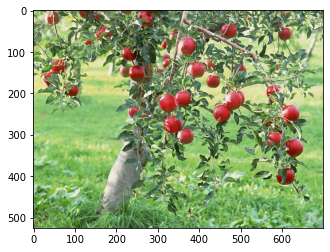

In [6]:
import pandas as pd
image_path = p_join(data_fpath, "apples.jpg")

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [7]:
audio_name = p_join(data_fpath, "brand1.wav")
audio_sample_sf, audio_sample = wavfile.read(p_join(data_fpath, "brand1.wav"))
audio_sample = audio_sample / 32767.0
print("duration:", len(audio_sample), "sample rate:", audio_sample_sf, "length=", len(audio_sample)/audio_sample_sf)
Audio(audio_sample, rate=audio_sample_sf)

duration: 63923 sample rate: 8000 length= 7.990375


## 1. Brightness from Amplitude
First a relatively simple method that just changes brightness according to mean amplitude. The intensity can be varied

In [29]:
frames = get_features(audio_sample, audio_sample_sf, 0.1)
print("Generating {} images".format(len(frames)))
intensity = 100
imgs = [ change_brightness2(img, (frame['amplitude_abs_mean'] - 0.5) * 1.8 * intensity) for i, frame in enumerate(frames) ]
print("Done")

video_name = 'output.avi'
duration_s = len(audio_sample) / audio_sample_sf
fps = len(imgs) / duration_s
generate_video(imgs, fps, video_name)
video_out_name = "output_brightness.mp4"
merge_video_audio(video_name, fps, audio_name, video_out_name)

Generating 320 images
Done
Moviepy - Building video output_brightness.mp4.
MoviePy - Writing audio in output_brightnessTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video output_brightness.mp4



Moviepy - Done !
Moviepy - video ready output_brightness.mp4


In [30]:
%%HTML
<div align="middle">
<video width="50%" controls>
      <source src= "output_brightness.mp4" type="video/mp4">
</video></div>

## 2. RGB matching

In this method we again use amplitudes in the frequency spectrum to modify the brightness but here we split the frequencies of a sample into three bins: one for high, one for middle and one for low frequencies. The idea is to change the mean RGB value of the image according to the change in the mean amplitude of the high, middle and low frequencies (HML). Therefore, we first need an initial sound sample that should correspond to the initial image. Then, for a new sound sample, we calculate mean HML values and use the difference to the initial HML values to change the RGB values. 


For a linear mapping we first have to define the range of amplitudes that we want to be able to map since the color range is fixed to $[0,255]$.
With the first sound sample we get the first three amplitudes (average amplitude of binned low, mid and high frequencies) and the initial mean RGB values from the image. We know that we want to map these amplitudes to these RGBs but how do we know to which RGBs we map a new amplitude? To do this, we first have to "calibrate" the linear mapping that will translate the amplitude to a color. 

Let's focus on the red channel and the low frequencies for now, since we should define a different mapping for each color channel anyhow. We know that the red values are in a fixed range $[0,255]$. For the amplitude we know the lower bound, 0, but not the upper. But we know another pair: the given initial amplitude and red value $(a_R, R)$. With these two points $(0,0)$ and $(a_R, R)$. we can define a linear mapping. There are several ways to get this mapping, we will do it by finding the maximum amplitude first:

$\frac{a_R}{R} = \frac{a_{max}}{255} \to a_{max} = \frac{255 \cdot a_R}{R}$

We use this to transfer a new amplitude $a_R'$ from the range $[0,a_{max}]$ to $[0,255]$ ot get the corresponding red value $R'$:

$R' = \frac{a'_R \cdot 255}{a_{max}}$


The following code implements the previously defined mapping with the mode "maximum"

The general structure is the following:

1. bin frequencies of sample into 3 bins (low, middle, high frequencies)
2. compute the mean amplitude of each bin
3. compute mean RGB values of image
4. ratio of new amplitudes to old amplitudes defines new RGB values
5. change image accordingly

repeat over all time samples of the audio

In [31]:
def get_bins(stft_sample_first, num_bins):
    bin_size = int(len(stft_sample_first)/num_bins)
    # bin the frequencies into three channels (low, middle, high frequencies) and compute average amplitude for each bin
    binned_freq = np.array([np.mean(stft_sample_first[i*bin_size : (i+1)*bin_size]) for i in range(num_bins)])
    return binned_freq

def get_bounds(initial_rgb, initial_ampl, max_ampl, color_range):
    lower = initial_rgb - ((initial_ampl/max_ampl) * color_range)
    upper = initial_rgb + ( (1-(initial_ampl/max_ampl)) * color_range)
    return lower, upper

def get_new_rgb_from_range(lower, upper, max_ampl, ampl):
    return (ampl/max_ampl) * (upper-lower) + lower

def sound_to_image(img, features, features_initial, sr, mode="maximum", window_size=70):
    """
    mode:
    maximum = map the whole amplitude range to the whole color range
    window = map the whole amplitude range to a color range of size window_size
    """
    mean_rgb = np.array([np.mean(img[:,:,i]) for i in range(3)])
    r = [mean_rgb[0]]
    g = [mean_rgb[1]]
    b = [mean_rgb[2]]

    # first sample bin frequencies and compute mean amplitude for each frequency
    stft_sample_first = np.abs(features_initial["stft"])
    num_bins = 3
    binned_freq_init = get_bins(stft_sample_first, num_bins)
    
    # find maximum amplitude of first sample to get upper bound for the mapping
    max_ampl = (255 * binned_freq_init) / mean_rgb
    # window
    if mode=="window":
        lower, upper = get_bounds(mean_rgb, binned_freq_init, max_ampl, window_size)
    else:
        lower = 0
        upper = 0

    # modify image according to incoming new sample
    stft_sample = np.abs(features["stft"])

    binned_freq_curr = get_bins(stft_sample, num_bins)
    # modify image accordingly
    # compute RGB values of previous image
    # prev_values = np.array([np.mean(im_prev[:,:,i]) for i in range(3)])
    # change according to change in frequency 
    # ratio of frequencies = ratio of colors
    if mode == "maximum":
        # ration of frequency to max frequency = ratio of color to max color
        new_values = (255 * binned_freq_curr) / max_ampl
    # get new values in given range (not from 0 to 255 but lower to upper which is a span of "color_range")
    else:
        new_values = get_new_rgb_from_range(lower, upper, max_ampl, binned_freq_curr)
    
    im_new = img.copy()
    im_new = change_rgb(im_new, new_values)
    
    return im_new

Example:
use the song and the image to create a video with the mapping:

In [32]:
print("Generating {} images".format(len(frames)))
imgs = [ sound_to_image(img, frame, frames[len(frames)//2], audio_sample_sf, mode="maximum") for i, frame in enumerate(frames) ]
print("Done")

video_name = 'output.avi'
duration_s = len(audio_sample) / audio_sample_sf
fps = len(imgs) / duration_s
generate_video(imgs, fps, video_name)
video_out_name = "output_maximum.mp4"
merge_video_audio(video_name, fps, audio_name, video_out_name)

Generating 320 images
Done
Moviepy - Building video output_maximum.mp4.
MoviePy - Writing audio in output_maximumTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video output_maximum.mp4



Moviepy - Done !
Moviepy - video ready output_maximum.mp4


In [33]:
%%HTML
<div align="middle">
<video width="50%" controls>
      <source src= "output_maximum.mp4" type="video/mp4">
</video></div>


However, if $a_R' > a_{max}$ we will get a value that is larger than 255. And indeed, we see that very often the computed RGB values exceed 255 and the image saturates. Because the biggest amplitude we can still map in the target range $[0,255]$ is defined by the initial red value and the initial amplitude, we cannot find a linear mapping that is guaranteed to never exceed 255.

But we can try to make smaller changes to the RGB so that the chance that the image saturates is lower. One way to do this is to map the whole amplitude range not to the whole color range but to a smaller range around the RGB values of the intial image.
In the previous mapping we have mapped the amplitude value 0 to color value 0 and amplitude max_ampl to 255. When the new amplitude extends the max amplitude, we exceed the limit of the color channels 255. Instead we now map the amplitude range $[0,a_{max}]$ to to a color range [upper, lower] such that the ratio $\frac{a_{max}-0}{a_R-0}$ is preserved in $\frac{upper-lower}{R-lower}$.

We calculate lower and upper like this:

$lower = f(0) = R - (\frac{a_R}{a_{max}} \cdot color\_range)$ </br>
$upper = f(a_{max}) = R + (1 - \frac{a_R}{a_{max}}) \cdot color\_range$

f is then defined as:

$f(a) = \frac{a}{a_{max}} \cdot (upper - lower) + lower$

If we now get a high amplitude and exceed the range [lower, upper] a bit, it is not such a big problem because we still get some valid ($\leq 255$) values. (It can still happen however. We have to decrease the window size then)

In [34]:
frames = get_features(audio_sample, audio_sample_sf, 0.1)
print("Generating {} images".format(len(frames)))
imgs = [ sound_to_image(img, frame, frames[len(frames)//2], audio_sample_sf, mode="window") for i, frame in enumerate(frames) ]
print("Done")

video_name = 'output.avi'
duration_s = len(audio_sample) / audio_sample_sf
fps = len(imgs) / duration_s
generate_video(imgs, fps, video_name)
video_out_name = "output_window.mp4"
merge_video_audio(video_name, fps, audio_name, video_out_name)

Generating 320 images
Done
Moviepy - Building video output_window.mp4.
MoviePy - Writing audio in output_windowTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video output_window.mp4



Moviepy - Done !
Moviepy - video ready output_window.mp4


In [35]:
%%HTML
<div align="middle">
<video width="50%" controls>
      <source src= "output_window.mp4" type="video/mp4">
</video></div>

---
## 3. Histogram matching

in this method we use the envelope of the sound in the time domain to modify the histogram of the image

1. compute each three discrete histograms with 256 bins from the envelope of two adjacent sound samples (-> 6 histograms)
2. compute the difference between each of the three pairs of histograms (-> 3 histograms)
3. compute the histograms of the three color channels of the input image (-> 3 histograms)
4. add the difference to the image histograms to get the histograms of the target image (-> 3 histograms)
5. perform histogram matching: change the initial color channels such that their histograms are distributed like the new histograms
6. put the three new color channels together to form the new image 

### Example for black and white image / only one image channel

get shape of the image channels and determine the scale of change that we want (large number will change the image a lot, smaller number less)

In [8]:
h,w,d = img.shape # image height and with to know the sum of the bins of the image histogram
scale = int(h*w)
print(f"scale of change = {scale}")

scale of change = 367500


function that "discretizes" the envelope of a sound to a histogram of 256 bins

In [9]:
def envelope_to_histogram(sample, scale, plot=False):
    """
    takes sound sample and scale which defines the sum of all bins in the histogram.
    In an image this would be heigt*width = number of pixels
    scale has to be <= the number of pixels in the image channel
    
    returns histogram normalized that would correspond to an image with "scale" pixels
    """
    num_bins = 256 # one bin for each brightness level in an image
    bin_size = int(len(sample)/num_bins) # the amount of time steps that are summarized in one bin
    if plot:
        print(num_bins, "with size", bin_size)
    binned_envelope = np.array([np.mean(sample[i:i+bin_size]) for i in range(num_bins)])
    
    # if a sample has no sound we add a small value to each bin
    if binned_envelope.sum() < 0.1:
        binned_envelope += 1
    # normalize bins to sum=scale
    normalized_float = (binned_envelope/binned_envelope.sum()) * scale
    normalized = normalized_float.astype(int)
    # make sure that the sum is correct after conversion to integer
    while normalized.sum() != scale:
        normalized_float = normalized_float % 1 # get only digits after comma
        idx_biggest_number = np.argmax(normalized_float)
        normalized[np.argmax(normalized_float)] += 1
        normalized_float[idx_biggest_number] = 0
    return normalized

sum should be 367500: True


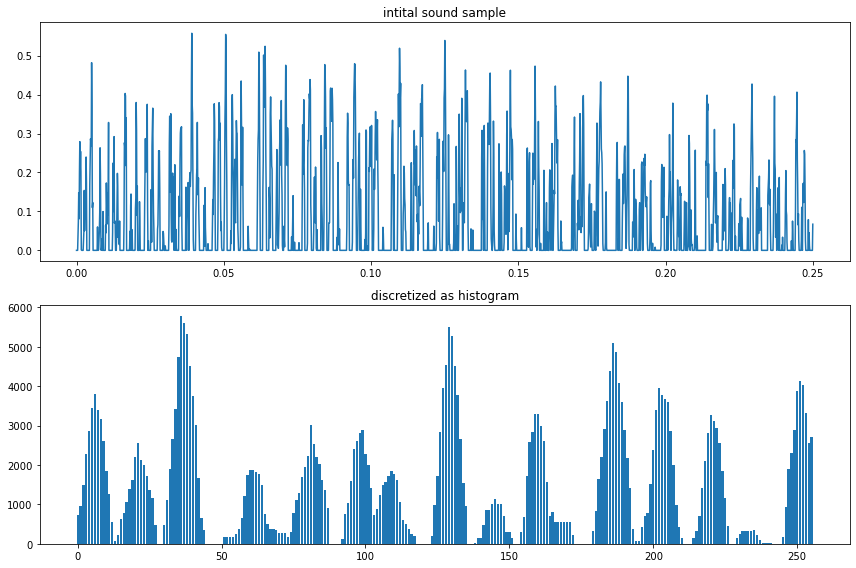

In [10]:
i = 6
sample_len = 2000 # how long the samples are, affects the quality of the histogram
# use only the positive part 
audio_pos = audio_sample
audio_pos[audio_pos<0] = 0

fig, ax = plt.subplots(2,1,figsize=(12,8))
# initial sound sample that should correspond to the initial image histogram
sample1 = audio_pos[sample_len*(i-1):sample_len*i]
ax[0].plot(np.linspace(0,len(sample1)/audio_sample_sf,len(sample1)), sample1)
ax[0].set_title("intital sound sample")

hist1 = envelope_to_histogram(sample1, scale)
print(f"sum should be {scale}: {hist1.sum()==scale}")
        
ax[1].bar(np.arange(256), hist1)
ax[1].set_title("discretized as histogram")
fig.tight_layout()

calculate the histogram of the next snippet

sum should be 367500: True


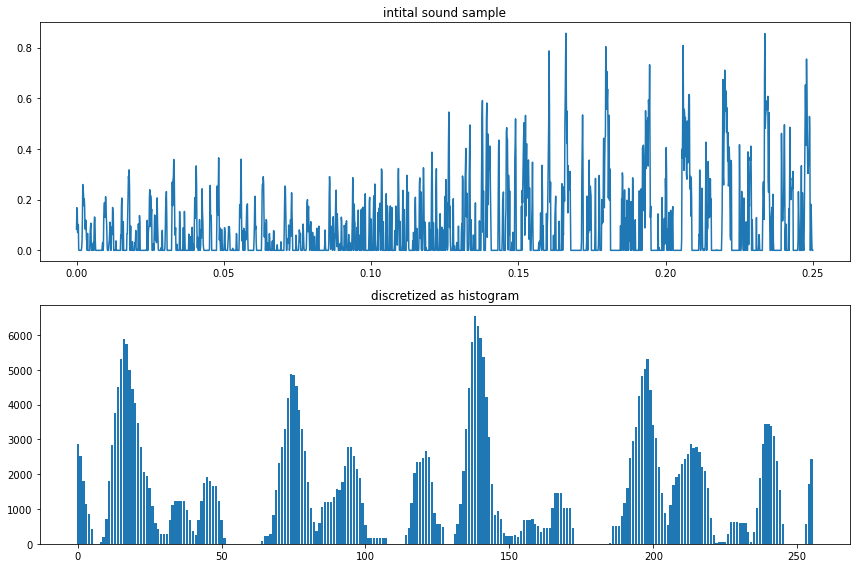

In [11]:
j = i+1
sample2 = audio_pos[sample_len*(j-1):j*sample_len]

fig, ax = plt.subplots(2,1,figsize=(12,8))
ax[0].plot(np.linspace(0,len(sample2)/audio_sample_sf,len(sample2)), sample2)
ax[0].set_title("intital sound sample")

hist2 = envelope_to_histogram(sample2, scale)
print(f"sum should be {scale}: {hist2.sum()==scale}")

ax[1].bar(np.arange(256), hist2)
ax[1].set_title("discretized as histogram")
fig.tight_layout()

Now, we can compute the difference between the two histograms. As we know that both histograms have the same amount of "pixels" (sum = scale), the sum of the difference should be 0

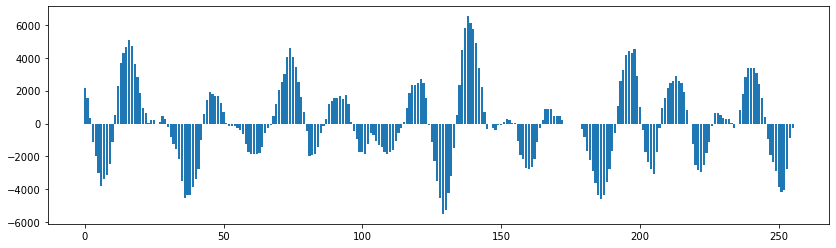

sum should be 0: True. The type needs to be int: int32


In [12]:
diff = (hist2 - hist1).astype(int)
plt.bar(np.arange(256), diff)
plt.show()
print(f"sum should be 0: {diff.sum()==0}. The type needs to be int: {diff.dtype}")
assert(diff.sum()==0)

We now know the change that we want to apply to the image histogram. To apply it we first need to compute the histogram of the initial image.

the image has 367500 pixels


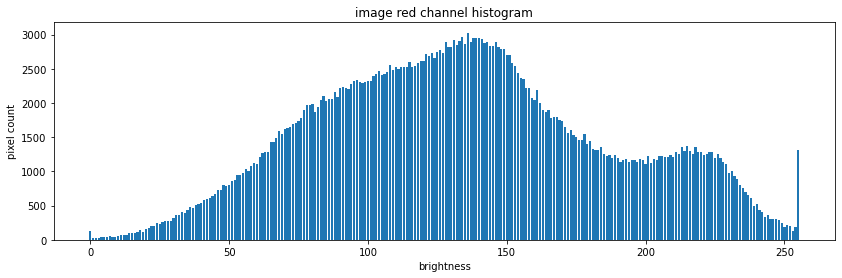

In [13]:
idx, counts = np.unique(img[:,:,0], return_counts = True)
print(f"the image has {np.sum(counts)} pixels")
x_ax = np.arange(256)
hist_im = np.zeros(256, dtype=int)
hist_im[idx] = counts
plt.bar(x_ax, hist_im)
plt.title("image red channel histogram")
plt.ylabel("pixel count")
plt.xlabel("brightness")
plt.show()

We compute the histogram of the new image by adding the calculated difference to the initial image histogram.
We see that we still have integers and that the amount of pixels in the histogram corresponds to the image shape.

But as the difference can be negative, it can happen that some bins become negative as well. We cannot have a negative number of pixel of a certain brightness, therefore we set these bins to 0. 

But then the amount of pixels represented in the histogram does not correspont to the amount of pixels in the image anymore. So we normalize to h*w.

However, the resulting histogram is not of type int anymore, and we cannot have partial pixels of a specific brightness so we cast to int.

Casting to int messes again with the amount of pixels in the histogram because the floats are simply cut off.

dtype=int32, number of pixels=367500==367500=image shape


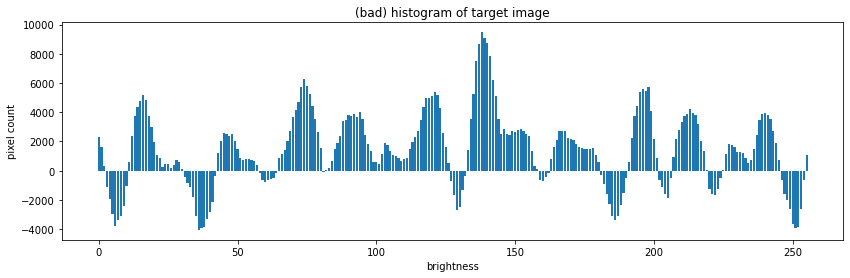

set negative bins to 0 
Pixels in histogram = 482248 vs pixels in image = 367500. dtype=int32
normalized histogram 
Pixels in histogram = 367500.0 vs pixels in image = 367500. dtype=float64, e.g. number of pixels with brightness=0: 1732.92
Cast to int 
Pixels in histogram = 367409 vs pixels in image = 367500


In [14]:
y_ax = hist_im + diff
print(f"dtype={y_ax.dtype}, number of pixels={y_ax.sum()}=={h*w}=image shape")
plt.bar(x_ax, y_ax)
plt.title("(bad) histogram of target image")
plt.xlabel("brightness")
plt.ylabel("pixel count")
plt.show()

# in case some bins are negative now set to 0 
y_ax[y_ax<0]=0 # make positive
print(f"set negative bins to 0 \nPixels in histogram = {y_ax.sum()} vs pixels in image = {h*w}. dtype={y_ax.dtype}")

y_ax_float = (y_ax/y_ax.sum())*w*h # normalize again to w*h to have the correct pixel amount
print(f"normalized histogram \nPixels in histogram = {y_ax_float.sum()} vs pixels in image = {h*w}. dtype={y_ax_float.dtype}, e.g. number of pixels with brightness=0: {y_ax_float[0]:.6}")

y_ax = y_ax_float.astype(int)
print(f"Cast to int \nPixels in histogram = {y_ax.sum()} vs pixels in image = {h*w}")

To add again the pixels that were cut off, we manually pick the entry that is closest to the next highest integer and round them up until the sum is correct 

(in the floating point histogram out of e.g. 12.66 and 123.12 we would pick 12.66 and set the corresponding entry in the integer histogram from 12 to 13)

sum should be h*w: True


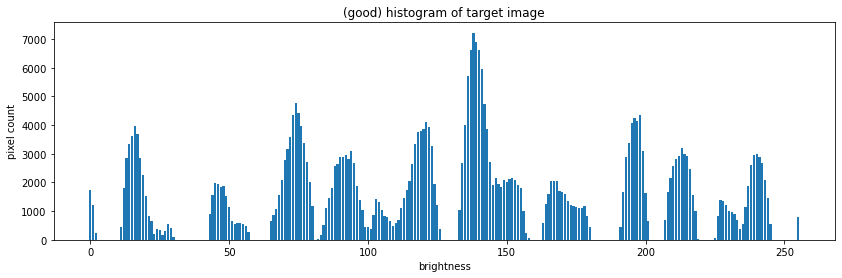

In [15]:
while y_ax.sum() != w*h:
    y_ax_float = y_ax_float % 1 # get only digits after comma
    idx_biggest_number = np.argmax(y_ax_float)
    y_ax[idx_biggest_number] += 1
    y_ax_float[idx_biggest_number] = 0
print(f"sum should be h*w: {h*w==y_ax.sum()}")
assert(h*w==y_ax.sum())

x_ax = np.arange(256)
plt.bar(x_ax, y_ax)
plt.xlabel("brightness")
plt.ylabel("pixel count")
plt.title("(good) histogram of target image")
plt.show()

now we have the histogram of the image that we want to create. Now we need to make an actual image from this histogram to use as reference image in the histogram matching.

The pixel distribution does not matter, it is only important that we have an image with the desired histogram since the method that does the actual matching (match_histograms of scikit image) requires an image as the reference and not a histogram.

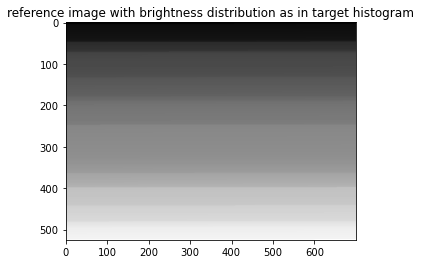

In [16]:
im_ref = np.zeros((h,w), dtype=np.uint8)
intensity_bar = 0 # [0,255] which bar we are in right now
count = 0 # keep track of height of bar
for i in range(h):
    for j in range(w):
        while count == y_ax[intensity_bar]:
            intensity_bar += 1
            count = 0
        im_ref[i,j] = intensity_bar
        count += 1
                    
plt.imshow(im_ref, cmap="gray")
plt.title("reference image with brightness distribution as in target histogram")
plt.show()

Finally, we can map the input image to an image with the given histogram using scikit's function:

uint8 uint8


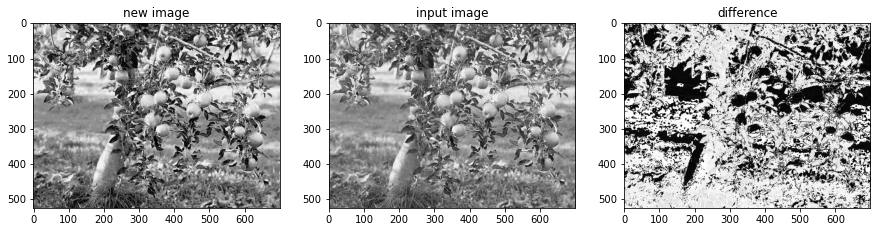

In [17]:
from skimage.exposure import match_histograms

next_im = match_histograms(img[:,:,0], im_ref,multichannel=False).astype(np.uint8)

fig, ax = plt.subplots(1,3, figsize=(15,8))
ax[0].imshow(next_im, cmap="gray")
ax[0].set_title("new image")
ax[1].imshow(img[:,:,0], cmap="gray")
ax[1].set_title("input image")
ax[2].imshow(next_im-img[:,:,0], cmap="gray")
ax[2].set_title("difference")
print(img[:,:,0].dtype, next_im.dtype)

We can also check if the histogram of the new image corresponds to the one we want

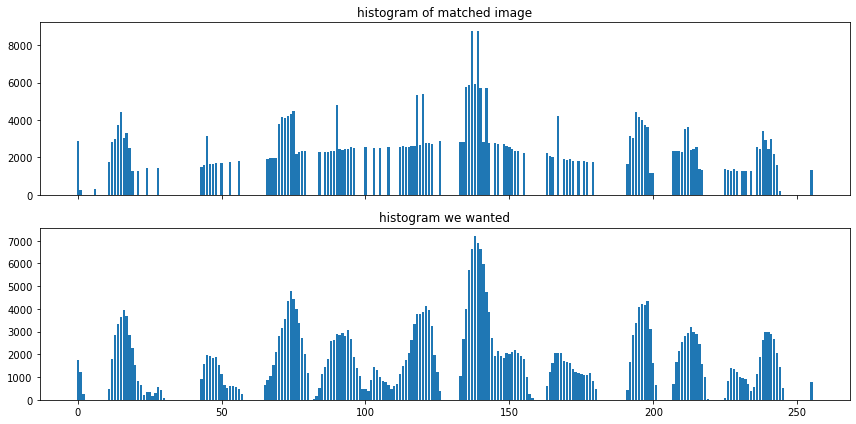

In [18]:
fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)

idx, counts = np.unique(next_im, return_counts = True)
hist_im = np.zeros(256, dtype=int)
hist_im[idx] = counts
ax[0].bar(x_ax, hist_im)
ax[0].set_title("histogram of matched image")

ax[1].bar(x_ax, y_ax)
ax[1].set_title("histogram we wanted")
fig.tight_layout()

eh close enough.

put all this stuff in functions:

In [19]:

def get_reference_image(im_channel, diff_sound_hist):
    """
    @param im_channel the image channel we want to change
    @param diff_sound_hist the difference between two sound histograms according to which we want to modify the channel
    get difference of two sound histograms add to initial channel and compute reference image for the channel
    the reference image is an image with the desired histogram but not the image content 
    it can be used for histogram mapping with scipys match_histograms function
    """
    h,w = im_channel.shape
    
    # histogram of initial color channel
    idx, counts = np.unique(im_channel, return_counts = True)
    hist_im = np.zeros(256, dtype=int)
    hist_im[idx] = counts
    
    # add difference to image histogram
    y_ax = hist_im + diff_sound_hist
    
    # perform all this normalization to have the correct pixel amount
    y_ax[y_ax<0]=0 # make positive
    y_ax_float = (y_ax/y_ax.sum())*w*h # normalize again to w*h to have the correct pixel amount
    y_ax = y_ax_float.astype(int)
    while y_ax.sum() != w*h:
        y_ax_float = y_ax_float % 1 # get only digits after comma
        idx_biggest_number = np.argmax(y_ax_float)
        y_ax[idx_biggest_number] += 1
        y_ax_float[idx_biggest_number] = 0
    
    # check that pixel amount is correct
    assert(h*w==y_ax.sum())
    
    # build an image with the desired pixel histogram, the position of each pixel does not matter
    im_ref = np.zeros((h,w), dtype=np.uint8)
    intensity_bar = 0 # [0,255] which bar we are in right now
    count = 0 # keep track of height of bar
    for i in range(h):
        for j in range(w):
            while count == y_ax[intensity_bar]:
                intensity_bar += 1
                count = 0
            im_ref[i,j] = intensity_bar
            count += 1
            
    return im_ref



### color image
Because each color channel has its own histogram we do that for all three color channels:

In [20]:

def get_sub_samples(sample, num=3):
    """
    function that devides a sound sample into three equal sized sound samples (one for each color channel)
    """
    subsample_len = int(len(sample)/num)
    return sample[:subsample_len], sample[subsample_len:subsample_len*2], sample[subsample_len*2:subsample_len*3]

def image_from_histograms(sample1, sample2, im, scale):
    """
    sample1 = reference sample
    sample2 = new sample
    """
    
    # cut into three subsamples and transform envelopes to histograms
    r1, g1, b1 = (envelope_to_histogram(subsample, scale) for subsample in get_sub_samples(sample1))
    r2, g2, b2 = (envelope_to_histogram(subsample, scale) for subsample in get_sub_samples(sample2))
    
    # reference image in which we store the manipulated color channels
    ref_im = np.zeros(im.shape)
    
    # calculate the differences between the three channels
    diff_red = r2-r1
    diff_blue = b2-b1
    diff_green = g2-g1
    #print(f"sum should be scale ={scale}: {r1.sum()==scale}, {r2.sum()==scale}, {b1.sum()==scale}, {b2.sum()==scale}, {g1.sum()==scale}, {g2.sum()==scale}")
    #print(len(diff_red))
    
    # get reference image for each channel
    ref_im[:,:,0] = get_reference_image(im[:,:,0], diff_red)
    ref_im[:,:,1] = get_reference_image(im[:,:,1], diff_green)
    ref_im[:,:,2] = get_reference_image(im[:,:,2], diff_blue)
    
    # do the actual matching
    new_im = match_histograms(im, ref_im, multichannel=True)
    return new_im

def match_histograms_from_envelope(features1, features2, img):
    # keep the same scale as before
    h,w,d = img.shape # image height and with to know the sum of the bins of the image histogram
    scale = int(h*w)

    sample1 = features1["values"]
    sample1[sample1<0] = 0
    # use only positive part
    sample2 = features2["values"]
    sample2[sample2<0] = 0
    
    if len(sample1) <= 256*3:
        print("reference sample is too short")
        return img
    if len(sample2) <= 256*3:
        print("new sample is too short")
        return img
    
    new_im = image_from_histograms(sample1, sample2, img, scale)
    return new_im

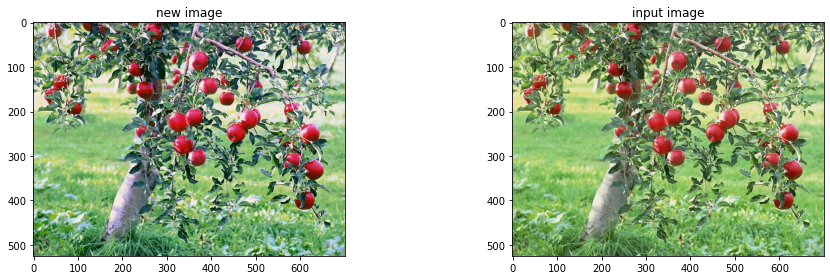

In [21]:
new_im = image_from_histograms(sample1, sample2, img, scale)

fig, ax = plt.subplots(1,2)
ax[0].imshow(new_im)
ax[0].set_title("new image")
ax[1].imshow(img)
ax[1].set_title("input image")
fig.tight_layout()

In [24]:
frames = get_features(audio_sample, audio_sample_sf, 0.3)
print("Generating {} images".format(len(frames)))
imgs = [ match_histograms_from_envelope(frame, frames[len(frames)//2], img) for i, frame in enumerate(frames) ]
print("Done")

video_name = 'output.avi'
duration_s = len(audio_sample) / audio_sample_sf
fps = len(imgs) / duration_s
generate_video(imgs, fps, video_name)
video_out_name = "output_histogram.mp4"
merge_video_audio(video_name, fps, audio_name, video_out_name)

Generating 107 images
Done
Moviepy - Building video output_histogram.mp4.
MoviePy - Writing audio in output_histogramTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video output_histogram.mp4



Moviepy - Done !
Moviepy - video ready output_histogram.mp4


In [25]:
%%HTML
<div align="middle">
<video width="50%" controls>
      <source src= "output_histogram.mp4" type="video/mp4">
</video></div>

The split of the envelope into three disjoint time samples is quite arbitrary which is why this method does not necessarily give meaningful results. 

---
## 4. Drawing shapes
A nice function that draws shapes on the image which move, change colors and sizes according to frequency and amplitude

Input: frequency, amplitude, time + hyperparameters

Parameters:
- angle within spiral: frequency, time
- distance from centre: time, freqency
- oscillation magnitude: frequency
- oscillation frequency: frequency
- alpha: amplitude, frequency
- radius: amplitude, frequency
- color: frequency

In [36]:
def draw_shapes(img, features, t, sr):
    img = img.copy()
    h, w, _ = img.shape
    db_threshold = 8
    center_x, center_y = w//2, h//2
    
    frequencies = librosa.fft_frequencies(sr=sr, n_fft=features['param_n_fft'])
    freq_min, freq_max = 30, 15000 # minimum and maximum frequencies to draw
    freq_indices = (frequencies >= freq_min) & (frequencies <= freq_max) # indices of frequencies to draw
    frequencies = frequencies[freq_indices]
    
    for i, val in enumerate(features['stft_db'][freq_indices]):
        shapes = np.zeros_like(img, np.uint8)
        mask = np.zeros_like(img, np.uint8)
    
        magnitude = val - db_threshold
        if magnitude <= 0:
            continue
        freq = frequencies[i]
        rel_frequency = (np.log(freq) - np.log(freq_min)) / (np.log(freq_max) - np.log(freq_min)) # a number between 0 (=lowest frequency) and 1 (=highest frequency)
        def spiral(x):
            x = np.interp(x, [0, 0.2, 1.], [0., 0.1, 1.])
            magnitude = x ** 0.5 * 0.6
            magnitude_offset = 0.1 * np.interp(x, [0, 1], [0.2, 1]) * np.sin((2*np.pi*t + 1000) * np.interp(x, [0,1], [0.5, 4]))
            magnitude += magnitude_offset
            angle = 2*np.pi* (2*x - t*0.6)
            point = (
                center_x + int( magnitude * np.cos(angle) * min(w,h) ),
                center_y + int( magnitude * np.sin(angle) * min(w,h) )
            )
            return point
        intensity = np.log(magnitude+1) * np.interp(rel_frequency, [0,1], [1., 0.2])
        center = spiral(rel_frequency)
        radius = int(intensity * min(h, w) * 0.03)
        rgb = np.array(cm.hsv(1 - rel_frequency))*255
        alpha = np.clip(
            intensity * 0.35,
            0, 1)
        
        #cv2.circle(img, center, radius, rgba, cv2.FILLED)
        cv2.circle(shapes, center, radius, rgb, cv2.FILLED)
        cv2.circle(mask, center, radius, (255,255,255), cv2.FILLED)
    
        # Generate output by blending image with shapes image, using the mask
        mask = mask.astype(bool)
        img[mask] = cv2.addWeighted(img, alpha, shapes, alpha, 0)[mask]
    return img

In [37]:
frames = get_features(audio_sample, audio_sample_sf, 0.1)
print("Generating {} images".format(len(frames)))
imgs = [ draw_shapes(img, frame, i/(len(frames)-1), audio_sample_sf) for i, frame in enumerate(frames) ]
print("Done")
video_name = 'output.avi'
duration_s = len(audio_sample) / audio_sample_sf
fps = len(imgs) / duration_s
generate_video(imgs, fps, video_name)
video_out_name = "output_brightness.mp4"
merge_video_audio(video_name, fps, audio_name, video_out_name)

Generating 320 images
Done
Moviepy - Building video output_brightness.mp4.
MoviePy - Writing audio in output_brightnessTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video output_brightness.mp4



Moviepy - Done !
Moviepy - video ready output_brightness.mp4


In [38]:
%%HTML
<div align="middle">
<video width="50%" controls>
      <source src= "output_brightness.mp4" type="video/mp4">
</video></div>

---
## 5. Entropy/Onset differences

In [39]:
def compute_rhythm(song):
    """
    Outputs a list of timestamps, in seconds, for which 
    onsets were detected by using the default onset 
    detection function. 
    """
    # Onsets
    onsets_string = subprocess.check_output(['aubioonset', '-i', song])
    onsets = onsets_string.decode("utf-8").strip().split('\n')
    onsets = [float(onset) for onset in onsets]
    # Diffs
    # Gives us a list of timings between onsets
    diffs = np.abs(np.diff(onsets)) # Calculate the n-th discrete difference along the given axis
    grid = np.linspace(0, 10, 1000)
    density = scipy.stats.gaussian_kde(diffs)
    hist = density(grid)
    # Entropy
    entropy = scipy.stats.entropy(hist) # Shannon's entropy 

    return {
    'entropy': entropy,
    'recording': song,
    'onsets': onsets,
    'diffs': diffs,
    'hist': hist,
    'grid': grid
    }

In [40]:
def generateOnsetDiffs(values):
    print('od')

    onsets = values['onsets']
    diffs = values['diffs']

    plt.title('Onset Diffs')
    plt.ylabel('Onset Time Difference (s)')
    plt.xlabel('Time (s)')
    graphDiffs = np.append(diffs, [0])
    plt.plot(onsets, graphDiffs)
    plt.show()

In [41]:
def generateSmoothedOnsetHistogram(values,ax):
    """
    Corrects the statistical errors in the observation
    of the onsets. We use Gaussian kernels as a specific 
    shape in estimating the actual data's shape (since we
    assume the musicians' mistakes are normally distributed).
    """
    print('soh')

    diffs = values['diffs']
    hist = values['hist']
    grid = values['grid']

    ax.set_title('Smoothed Onset Diff Histogram')
    ax.set_ylabel('Count')
    ax.set_xlabel('Onset Time Difference (s)')
    bins = ax.hist(diffs, bins=300, density=True)
    histNorm = hist / np.max(hist) * np.max(bins[0])
    end = [i for i, v in enumerate(hist) if v > 1e-4][-1]
    ax.plot(grid[:end], histNorm[:end], 'g-')

In [42]:
#"data/Patti Austin - Thats Enough For Me.wav"
#audio_name = "data/snd.wav"

audio_name = p_join(data_fpath, "harry_styles.wav")
audio, sr = librosa.load(audio_name, sr=None)
if len(audio.shape) > 1: # if stereo, use only the left channel
    audio = audio.T[0]
audio = audio[0:10*sr] # keep max 10s of the audio
Audio(audio, rate=sr)

In [43]:
#res1 = compute_rhythm(audio_name)
print(p_join(data_fpath, "harry_styles.wav"))
res2 = compute_rhythm(p_join(data_fpath, "harry_styles.wav"))

C:\Users\Theresa\Documents\CS_Master\EPFL\CM\Project\AudioImagers\data\harry_styles.wav


FileNotFoundError: [WinError 2] Das System kann die angegebene Datei nicht finden

In [44]:
generateOnsetDiffs(res1)

NameError: name 'res1' is not defined

NameError: name 'res1' is not defined

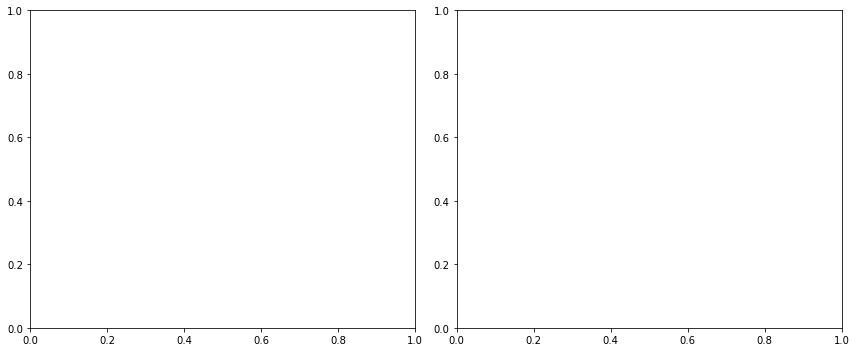

In [45]:
fig, axes = plt.subplots(1,2, tight_layout = True, figsize = (12,5))
axes.flatten()
generateSmoothedOnsetHistogram(res1, axes[0])
generateSmoothedOnsetHistogram(res2, axes[1])

The blue bars of the graph represent the onset difference while the green line represents the Parzen smoothed probability density function. So, the density of onset differences in the song.
We can see on the left-most plot, the onset time difference is mainly around 0.22 s. In other words, most onsets occurring in the song appear at an interval of 0.22s. Whereas, with "Watermelon Sugar" from Harry Styles, we've got more spread out onset time differences, which would underline a higher entropy. 

In [46]:
print(res1['entropy'])
print(res2['entropy'])

NameError: name 'res1' is not defined

As expected, the entropy is greater for the Harry Styles song (number 2). 

---

## Other methods for creating gifs
do we need that? </br>
why do we have 2 functions to get the frames (get_info and get_features) when we only use get_features?</br>
does the metric only work with get_info frames?

In [47]:
# function that takes audio info and image as an imput an returns set of images for the frame
def get_gif(info, img_address):
    img = cv2.imread(img_address)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ln = len(info)
    amplitudes = []
    for i in range(ln):
        amplitudes.append(info[i]['amplitude'].max())
    br_values = np.array(amplitudes) / min(amplitudes)
    # this arguments just hand picked, so the images looks different
    # for final version better use proper transformation
    a = 19.14
    b = -64.12
    br_values = br_values * a + b
    br_values = np.array(br_values, dtype=int)
    new_imgs = []
    for v in br_values:
        new_imgs.append(change_brightness(img, v))
    return new_imgs

In [48]:
from os.path import abspath
from os.path import join as p_join
PROJDIR = abspath('')
new_imgs = get_gif(frames, p_join(PROJDIR,'data/apple.jpg'))

KeyError: 'amplitude'

In [49]:
# basic visualization of images in result
fig = plt.figure(figsize=(20, 20))
for i in range(1,len(new_imgs)):
    fig.add_subplot(5,6,i)
    plt.imshow(new_imgs[i])
plt.show()

NameError: name 'new_imgs' is not defined

<Figure size 1440x1440 with 0 Axes>

In [50]:
# this function is for making gif, the problem I didn't find an argument on how to change the time for particular image
# so, it will need additional coding
import imageio
with imageio.get_writer(f'out.gif', mode='I') as writer:
    for new_img in new_imgs:
        writer.append_data(new_img)

NameError: name 'new_imgs' is not defined

Also, here we should collect the similarity metrics vector. 
Approximately, it should look like that:
```
def img_metric(imgs):
    vec = []
    for i in range(len(imgs) - 1):
        vec.append(rmse(imgs[i], imgs[i + 1]))
    return vec
    
def audio_metric(frames):
    ...
    return some_vec

audio_vec = normalize(audio_metric...)
img_vec = normalize(img_metric...)
Goal_metric = cosine_distance(audio_vec, img_vec)
```

The goal is to make the best goal metric, which will be equal to similarity between vectors.

In [51]:
# additional libraries for metrics
from sklearn.metrics import mean_squared_error as rmse
from skimage.measure import compare_mse as mse
from tqdm import tqdm
from scipy.spatial.distance import cosine
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

ImportError: cannot import name 'compare_mse' from 'skimage.measure' (C:\ProgramData\Anaconda3\lib\site-packages\skimage\measure\__init__.py)

In [52]:
def get_info(audio_name, window_size):
    # audio_name -- name of audiofile
    # window_size -- we split audio into frames, this is the length of the frame in seconds
    x, sr = librosa.load(audio_name)
    seconds = len(x) / sr
    frame_len = int(len(x) / (seconds / window_size))
    frames = []
    for ind in range(0, len(x) + 1, frame_len):
        current_amplitude = x[ind:ind + frame_len]
        fft = librosa.stft(current_amplitude, n_fft=len(current_amplitude), hop_length=len(current_amplitude))
        freqs = fft[:, 0]
        freqs = librosa.amplitude_to_db(abs(freqs))
        _, phase = librosa.magphase(fft)
        phase = phase[:, 0]
        frames.append({'amplitude':current_amplitude, 'frequency':freqs, 'phase':phase})
        #timbre = 0
    return frames
audio_name = 'data/snd.wav'
frames = get_info(audio_name, 0.5)

### the metric

In [53]:
new_imgs = get_gif(frames, 'data/apple.jpg')

In [54]:
def img_metric(imgs):
    vec = []
    for i in range(len(imgs) - 1):
        vec.append(np.sqrt(mse(imgs[i], imgs[i + 1])))
    return np.array(vec)

def audio_metric(frames):
    vec = []
    for i in tqdm(range(len(frames) - 1)):
        distance, _ = fastdtw(frames[i]['amplitude'], frames[i + 1]['amplitude'], dist=euclidean)
        vec.append(distance)
    return np.array(vec)

def cosine_distance(imgs, frames):
    img_vec = img_metric(new_imgs)
    audio_vec = audio_metric(frames)
    return cosine(img_vec, audio_vec)

print(cosine_distance(new_imgs, frames)) # the smaller the better since (1 - normed dot product)

NameError: name 'mse' is not defined

---
# UI

In [55]:
import glob
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.html.widgets import interactive

def display_h2(text):
    display(HTML('<h2>{}</h2>'.format(text)))

#--- Choose an audio file ---
selected_audio = ([], 0, "")
def display_audio(audio_file):
    global selected_audio
    audio, sr = librosa.load(audio_file, sr=None)
    if len(audio.shape) > 1: # If stereo, use only the left channel
        audio = audio.T[0]
    audio = audio[0:10*sr] # Keep max 10s of the audio
    selected_audio = audio, sr, audio_file
    
    print(audio_file)
    display(Audio(audio, rate=sr))
    plt.plot(audio)
    plt.show()

display_h2("1. Choose an audio file")
dropdown_audio_file = widgets.Dropdown(options=sorted(glob.glob('data/*.wav')), description="Audio file:")
display(interactive(display_audio, audio_file=dropdown_audio_file))

#--- Choose an image ---
selected_image = np.array([])
def select_image(image_file, width):
    global selected_image
    img = cv2.imread(image_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = resize_image(img, target_width=width)
    selected_image = img
    
    print("{} ({}x{})".format(image_file, *img.shape))
    plt.imshow(img)

display_h2("2. Choose an image")
dropdown_image_file = widgets.Dropdown(options=sorted(glob.glob('data/*.jpg')), description="Image:")
inttext_image_width = widgets.BoundedIntText(value=480, min=1, max=4096, step=1, description='Target width (px):')
display(interactive(select_image, image_file=dropdown_image_file, width=inttext_image_width))

#--- Selected effects ---
display_h2("3. Choose effects")
selected_effects = widgets.Select(description="Selected effects", options=[])
display(selected_effects)

button_remove_selected_effects = widgets.Button(description="Remove selected")
def on_button_remove_selected_effects_click(b):
    options = list(selected_effects.options)
    del options[selected_effects.index]
    selected_effects.options = options
button_remove_selected_effects.on_click(on_button_remove_selected_effects_click)
display(button_remove_selected_effects)

display(HTML("""<hr style="width: 350px; margin-left: 0;"/>"""))

#--- Add an effect ---
selected_effect = {}
def select_effect(effect, **kwargs):
    def accept_params(**params):
        global selected_effect
        selected_effect = {
            "effect": effect,
            **params
        }
    return accept_params

def effect_parameters(effect):
    params = {}
    if effect == 'amplitude_brightness':
        params['intensity'] = widgets.FloatSlider(
            value=0.5,
            min=0,
            max=1.0,
            step=0.01,
            description='Intensity:',
            readout_format='.2f',
        )
    display(interactive(select_effect(effect), **params))

dropdown_effect = widgets.Dropdown(description="Effect:", options=[
    ('(No-op)', 'no-op'),
    ('Amplitude envelope -> Brightness', 'amplitude_brightness'),
    ('Match histogram from amplitude envelope', 'match_histograms_from_envelope'),
    ('Low/Mid/High freq. amplitude -> R/G/B channels intensity', 'frequency_bins'),
    ('Draw shapes', 'draw_shapes'),
])
display(interactive(effect_parameters, effect=dropdown_effect))

button_add_effect = widgets.Button(description="Add effect")
def on_button_add_effect_click(b):
    global selected_effects
    selected_effects.options = list(selected_effects.options) + [selected_effect]
    #selected_effects.options = list(selected_effects.options) + ["a"]
button_add_effect.on_click(on_button_add_effect_click)
display(button_add_effect)

#--- Applying selected effects ---
def apply_effect(img, features, t, sr, features_initial, effect):
    if effect['effect'] == 'amplitude_brightness':
        return change_brightness2(img, (features['amplitude_abs_mean'] - 0.5) * 2 * 255 * effect['intensity'])
    if effect['effect'] == 'match_histograms_from_envelope':
        return match_histograms_from_envelope(features_initial, features, img)
    if effect['effect'] == 'frequency_bins':
        return sound_to_image(img, features, features_initial, sr, mode="maximum")
    if effect['effect'] == "draw_shapes":
        return draw_shapes(img, features, t, sr)
    return img
        
def get_image_frame(img, features, t, sr, features_initial=0):
    for effect in selected_effects.options:
        img = apply_effect(img, features, t, sr, features_initial, effect)
    return img

def get_image_sequence(source_img, frames, sr, f, callback=None):
    """
    source_img = reference image
    frames = frame for each sample from audio file 
    sr = sampling rate from audio file
    f = method to be applied
    """
    def process_frame(i, frame):
        result = f(source_img, frame, i/(len(frames)-1), sr, frames[len(frames)//2])
        if callback:
            callback(i)
        return result
    return [ process_frame(i, frame) for i, frame in enumerate(frames) ]

#--- Generate the video ---
display_h2("4. Have fun!")
button_generate_video = widgets.Button(description="Generate a video")
output_generate_video = widgets.Output()
def on_button_generate_video_click(b):
    global output_generate_video
    with output_generate_video:
        clear_output(wait=True)

        audio, sr, audio_name = selected_audio
        img = selected_image

        # Calculate features
        print("Analyzing the audio file...")
        frames = get_features(audio, sr, 0.1)

        # apply effects to each frame
        print("Generating image frames...")
        frames_progress = widgets.IntProgress(min=0, max=len(frames))
        display(frames_progress)
        def frames_progress_callback(k):
            frames_progress.value = k
        imgs = get_image_sequence(img, frames, sr, get_image_frame, frames_progress_callback)
        frames_progress.close()

        # generate the video
        video_name = 'output_temp.avi' # intermediate file without audio

        duration_s = len(audio) / sr
        fps = len(imgs) / duration_s
        generate_video(imgs, fps, video_name)

        # merge the video with the original audio
        video_out_name = "output.mp4"
        merge_video_audio(video_name, fps, audio_name, video_out_name)

        # display the video
        display(HTML("""<video width="400" controls><source src="{}"></video>""".format(video_out_name)))

button_generate_video.on_click(on_button_generate_video_click)
display(button_generate_video, output_generate_video)

#--- Metric ---
display_h2("5. See the metric")

interactive(children=(Dropdown(description='Audio file:', options=('data\\Patti Austin - Thats Enough For Me.w…

interactive(children=(Dropdown(description='Image:', options=('data\\apple.jpg', 'data\\apples.jpg', 'data\\te…

Select(description='Selected effects', options=(), value=None)

Button(description='Remove selected', style=ButtonStyle())

interactive(children=(Dropdown(description='Effect:', options=(('(No-op)', 'no-op'), ('Amplitude envelope -> B…

Button(description='Add effect', style=ButtonStyle())

Button(description='Generate a video', style=ButtonStyle())

Output()